# Diablotin
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records (filter sets).  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.  Some information is pulled from the parameters.sqlite database that is saved in this repository.

### General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
%cd ..
import repo_functions as functions

T:\code\occurrence-records-wrangler


There is a bug with mpl_toolkits, the following code is a temp fix, hopefully.
https://stackoverflow.com/questions/52911232/basemap-library-using-anaconda-jupyter-notebooks-keyerror-proj-lib/54087410#54087410

In [2]:
os.environ['PROJ_LIB'] = r'c:\Users\nmtarr\AppData\Local\Continuum\miniconda3\envs\occurrences\Library\share'

### Set Variables
Fill out stuff in this cell.

In [3]:
species_id = 'bbcpex0'
summary_name = 'diablotin'
gbif_req_id = 'GBIFr9'
gbif_filter_id = 'GBIFf9'
workDir = 'T:/Occurrence_Records/'
codeDir = 'T:/Code/occurrence-records-wrangler/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 200
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + "Speed/" + species_id + gbif_req_id + gbif_filter_id + '.sqlite'

print("Notebook run " + str(t1))

Notebook run 2019-12-02 12:05:54.004265


In [4]:
connjup = sqlite3.connect(codeDir + 'parameters.sqlite')
cursorjup = connjup.cursor()

# Get some variables
years = connjup.execute("""SELECT years_range 
                           FROM gbif_requests WHERE request_id = '{0}'""".format(gbif_req_id)).fetchone()[0]
gap_id = connjup.execute("""SELECT gap_id
                            FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]
common_name = connjup.execute("""SELECT common_name
                                 FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]

# Species Concept
Display information on the species from the parameters.sqlite database.

In [5]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '',
 'common_name': 'black-capped petrel',
 'concept_vetted': 0,
 'detection_distance_meters': 300,
 'ebird_id': None,
 'end_year': None,
 'error_tolerance': 20,
 'fws_id': 'Pterodroma hasitata',
 'gap_id': '',
 'gbif_id': '2481477',
 'geometry': None,
 'itis_tsn': '174567',
 'migratory': '1',
 'notes': 'Based on FWS SSA, detection distance is a guess.',
 'pad': 1,
 'scientific_name': 'Pterodroma hasitata',
 'species_id': 'bbcpex0',
 'start_year': 1918,
 'wintering_months': ''}


# Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [6]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                     GBIFr9
source                           GBIF
lat_range                       27,41
lon_range                     -91,-75
years_range                 2000,2020
months_range                     1,12
geoissue                         None
coordinate                       True
country                          None
geometry                         None
continent                        None
creator                       N. Tarr
notes           Used for speed tests.
Name: 0, dtype: object


Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the occurrence record sqlite database.

In [7]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(gbif_filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                                               GBIFf9
dataset                                                                   GBIF
collection_codes_omit                                                         
institutions_omit                                                             
has_coordinate_uncertainty                                                   0
max_coordinate_uncertainty                                               10000
bases_omit                                                                    
protocols_omit                                                                
sampling_protocols_omit                                                       
issues_omit                                                                   
duplicates_OK                                                             True
creator                                                                N. Tarr
notes                   

In [8]:
functions.retrieve_gbif_occurrences(codeDir, species_id, inDir, spdb, gbif_req_id, gbif_filter_id, 
                                    default_coordUncertainty, SRID_dict, outDir, summary_name)

SPATIALITE_SECURITY set to relaxed
Created occurrence db: 0:00:07.373150
Got request params and sorted out geometry constraints: 0:00:00.002986
Downloaded records: 0:00:24.724118
	6009 records exist with the request parameters
Created summary table of request results: 0:00:01.776568
Performed post-request filtering: 0:00:00.264891
Summarized results of filtering: 0:00:00.268876
Inserted records: 0:00:00.179248
Updated occurrences table geometry column: 0:00:01.996646
Inserted records: 0:00:01.055585
DUPLICATES ON LATITUDE, LONGITUDE, DATE-TIME INCLUDED
Buffered points: 0:00:26.443117
Exported maps: 0:00:09.641658

Records saved in T:/Occurrence_Records/Outputs/Speed/bbcpex0GBIFr9GBIFf9.sqlite


### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [9]:
conn_occ= sqlite3.connect(spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

5980 records


# Descriptions of filtered records

### Locations

T:\code\occurrence-records-wrangler\repo_functions.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  height=3200000, width=5000000)
T:\code\occurrence-records-wrangler\repo_functions.py:44: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawstates(color='grey')
T:\code\occurrence-records-wrangler\repo_functions.py:45: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawcountries(color='grey')
T:\code\occurrence-records-wrangler\repo_functions.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  color=mapfile['linecolor'])


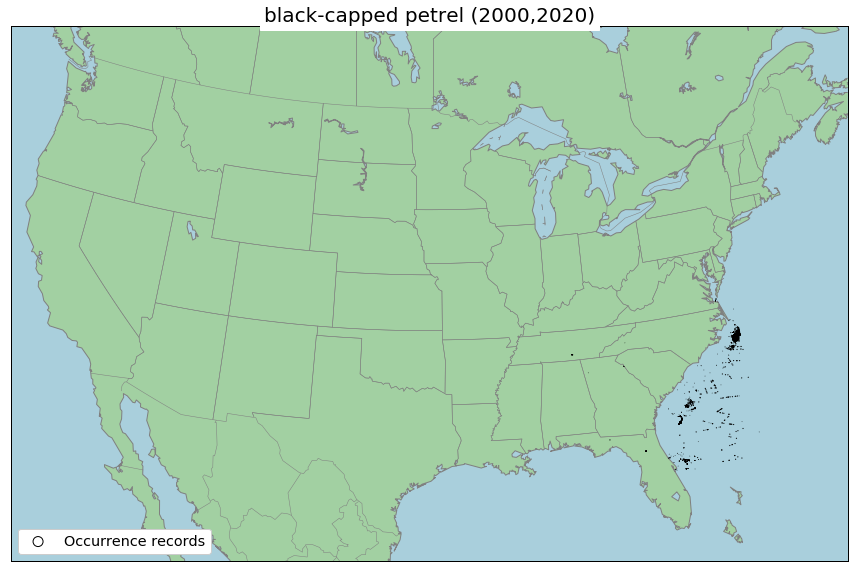

In [10]:
shp1 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
map_these=[shp1]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Runtime

In [11]:
t2 = datetime.now()
print(t2 - t1)

0:01:20.198809
